# Bayesian Randomized Benchmarking  Demo

## Two-qubit Standard and Interleaved RB on Hardware

This is a bayesian pyMC3 implementation on top of frequentist interleaved RB from qiskit experiments

Based on this [WIP tutorial](https://github.com/Qiskit/qiskit-experiments/blob/main/docs/tutorials/randomized_benchmarking.ipynb) 
on july 31 2021

Note: the lenght range for standard one-qubit RB was changed to np.arange(1, 2500, 250) because np.arange(1, 1000, 100) gave unreliable results with respect to the backend's reported EPG values, and this evenly for the least squared fit (LSF) and for the serial Monte Carlo process (SMC).

The hierarchical models are based on [equation 13 in this paper by Hincks et al.](https://arxiv.org/abs/1802.00401)

The models for interleaved RB use [equation 5 in this paper by Granade and al.](https://arxiv.org/abs/1404.5275)

In [1]:
import numpy as np
import copy
from qiskit_experiments.library import StandardRB, InterleavedRB
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library.randomized_benchmarking import RBUtils
import qiskit.circuit.library as circuits

# for retrieving gate calibration
from datetime import datetime
import qiskit.providers.aer.noise.device as dv

# import the bayesian packages
import pymc3 as pm
import arviz as az
import unif_bayesian_fitter as bf

In [2]:
simulation = False # make your choice here
if simulation:
    from qiskit.providers.aer import AerSimulator
    from qiskit.test.mock import FakeParis
    backend = AerSimulator.from_backend(FakeParis())
else:
    from qiskit import IBMQ
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = provider.get_backend('ibmq_bogota') # type here hardware backend  

In [3]:
# for WIP
import importlib
importlib.reload(bf)

<module 'unif_bayesian_fitter' from 'C:\\Users\\decpi\\OneDrive\\Documents\\qiskit-tutorials-master\\tutorials\\noise\\unif_bayesian_fitter.py'>

# Running standard 2-qubit RB

In [55]:
# describe RB experiment
interleaved_gate =''
physical_qubits = qubits = (0,1)
nQ = len(qubits)
scale = (2 ** nQ - 1) / 2 ** nQ # defined for the 2-qubit run
lengths = np.arange(1, 200, 30) 
lengths_1_qubit = np.arange(1, 2225, 225)
num_samples = 10
seed = 1010

In [23]:
# Run a 1-qubit RB expriment on each qubit to determine the error-per-gate of 1-qubit gates
expdata_1q = {}
epg_1q = []

In [24]:
for qubit in qubits:
    exp = StandardRB([qubit], lengths_1_qubit, num_samples=num_samples, seed=seed)
    expdata = exp.run(backend).block_for_results()
    expdata_1q[qubit] = expdata
    epg_1q += expdata.analysis_results()

In [25]:
# Run an RB experiment on 2 qubits
exp2 = StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)

# Use the EPG data of the 1-qubit runs to ensure correct 2-qubit EPG computation
exp2.set_analysis_options(epg_1_qubit=epg_1q)

# Run the 2-qubit experiment
expdata2 = exp2.run(backend).block_for_results()

# View result data
results2 = expdata2.analysis_results()

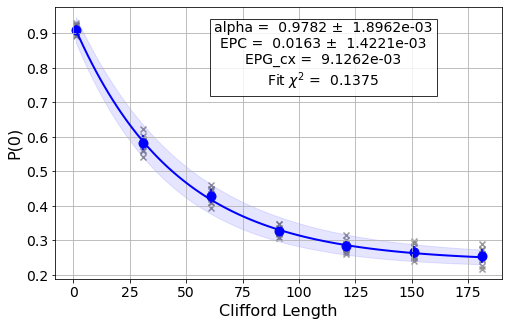

DbAnalysisResultV1
- name: @Parameters_RBAnalysis
- value: [0.68717351 0.97821877 0.23858326] ± [0.01933284 0.00189615 0.01638291]
- χ²: 0.1375203220944997
- extra: <3 items>
- device_components: ['Q0', 'Q1']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9782187745713069 ± 0.0018961529966763343
- χ²: 0.1375203220944997
- device_components: ['Q0', 'Q1']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.016335919071519822 ± 0.0014221147475072507
- χ²: 0.1375203220944997
- device_components: ['Q0', 'Q1']
- verified: False
DbAnalysisResultV1
- name: EPG_cx
- value: 0.009126244057453247
- χ²: 0.1375203220944997
- device_components: ['Q0', 'Q1']
- verified: False


In [26]:
# View result data
display(expdata2.figure(0))
for result in results2:
    print(result)

In [64]:
# example of interpolated EPC_cal for hardware experiments
# EPC0 + (t_exp - tO) * (EPC1 - EPC0) / (t1 - t0)
# code here:
epc_calib = 0.010745 + (22+40/60-7)*(0.008261 - 0.010745)/24
print('EPC calibration: {0:0.4e}'.format(epc_calib))

EPC calibration: 9.1235e-03


### 2-qubit experiment bayesian analysis

In [57]:
popt = expdata2.analysis_results()[0].value.value
pcov = expdata2.analysis_results()[0].extra['covariance_mat']
epc_est_fm = expdata2.analysis_results()[2].value.value
epc_est_fm_err = expdata2.analysis_results()[2].value.stderr

In [58]:
EPG_dic = {}
EPG_key = 'cx' #expdata2.analysis_results()[3].name
EPG_dic[EPG_key] = expdata2.analysis_results()[3].value.value 

In [59]:
nQ = len(qubits)
scale = (2 ** nQ - 1) / 2 ** nQ
desired_gate ='cx'

In [60]:
# get count data
Y = bf.get_GSP_counts(expdata2._data, len(lengths),range(num_samples))
experiment_type = expdata2._data[0]['metadata']['experiment_type']
physical_qubits = expdata2._data[0]['metadata']['physical_qubits']
shots = expdata2._data[0]['shots']

### Pooled model

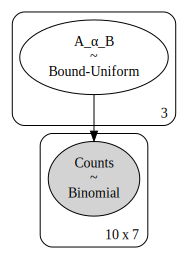

In [33]:
#build model
S2QBp_model = bf.build_bayesian_model(model_type="pooled",Y=Y,
                                       shots=shots,m_gates=lengths,
                                       popt = popt,
                                       pcov = pcov)
                                           
pm.model_to_graphviz(S2QBp_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A_α_B]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 94 seconds.


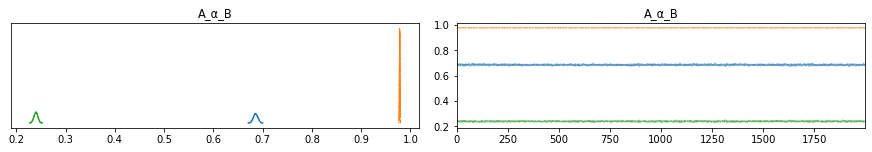

In [34]:
trace_p2 = bf.get_trace(S2QBp_model, target_accept = 0.95)

              mean        sd    hdi_3%   hdi_97%
A_α_B[0]  0.685734  0.004437  0.677406  0.693925
A_α_B[1]  0.978245  0.000447  0.977398  0.979058
A_α_B[2]  0.239709  0.003830  0.232612  0.246947 

Model:    Frequentist        Bayesian
_______________________________________
EPC         1.634e-02        1.632e-02 
± sigma    ± 1.422e-03      ± 3.353e-04 
EPG cx      9.126e-03        9.115e-03


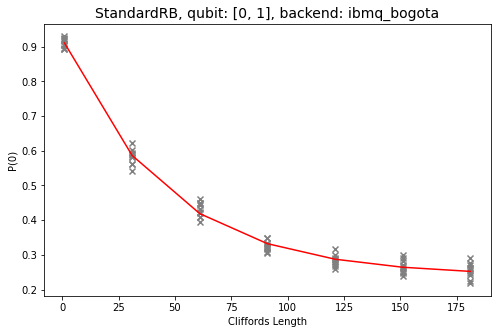

In [61]:
bf.RB_bayesian_results(S2QBp_model, trace_p2, lengths,
                       epc_est_fm,
                       epc_est_fm_err,
                       experiment_type,
                       scale,                       
                       num_samples, Y, shots, physical_qubits, interleaved_gate, backend,
                       EPG_dic = EPG_dic,
                       routine = 'build_bayesian_model')

In [65]:
# example of interpolated EPC_cal for hardware experiments
# EPC0 + (t_exp - tO) * (EPC1 - EPC0) / (t1 - t0)
# code here:
epc_calib = 0.010745 + (22+40/60-7)*(0.008261 - 0.010745)/24
print('EPC calibration: {0:0.4e}'.format(epc_calib))

EPC calibration: 9.1235e-03


### Hierarchical model

model: [equation 13 in this paper](https://arxiv.org/abs/1802.00401)

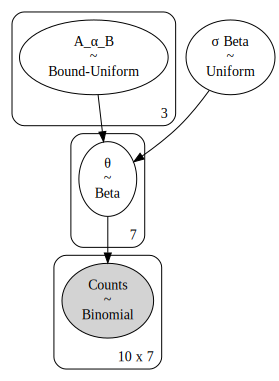

In [36]:
#build model
S2QBh_model = bf.build_bayesian_model(model_type="h_sigma",Y=Y,shots=shots,m_gates=lengths,
                                           popt = popt,
                                           pcov = pcov,
                                           sigma_theta=0.001,sigma_theta_l=0.0005,sigma_theta_u=0.0015)
                                           
                                          
pm.model_to_graphviz(S2QBh_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, σ Beta, A_α_B]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 275 seconds.


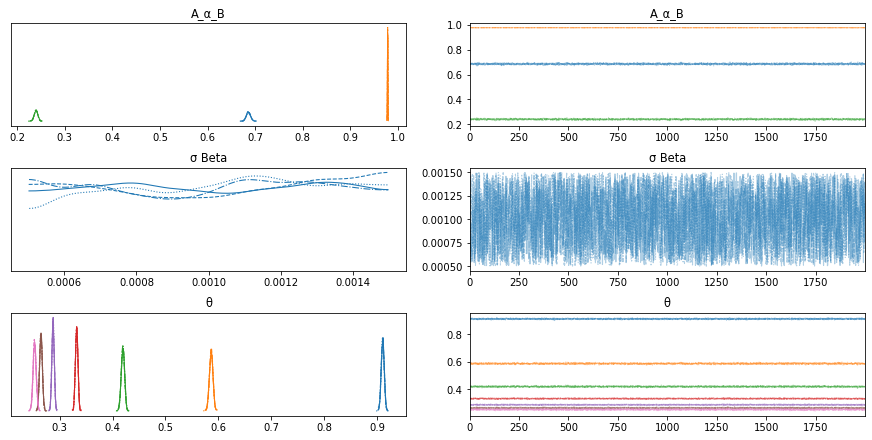

In [37]:
trace_h2 = bf.get_trace(S2QBh_model)

              mean        sd    hdi_3%   hdi_97%
A_α_B[0]  0.685791  0.004418  0.677805  0.694394
A_α_B[1]  0.978244  0.000448  0.977373  0.979070
A_α_B[2]  0.239677  0.003766  0.232620  0.246727
σ Beta    0.001010  0.000290  0.000547  0.001484
θ[0]      0.910562  0.002784  0.905198  0.915643
θ[1]      0.586340  0.003360  0.579767  0.592323
θ[2]      0.419457  0.003093  0.413888  0.425574
θ[3]      0.332111  0.002357  0.327699  0.336402
θ[4]      0.287449  0.002230  0.283123  0.291521
θ[5]      0.264582  0.002576  0.259851  0.269504
θ[6]      0.252625  0.002937  0.247317  0.258465 

Model:    Frequentist        Bayesian
_______________________________________
EPC         1.634e-02        1.632e-02 
± sigma    ± 1.422e-03      ± 3.360e-04 
EPG cx      9.126e-03        9.116e-03


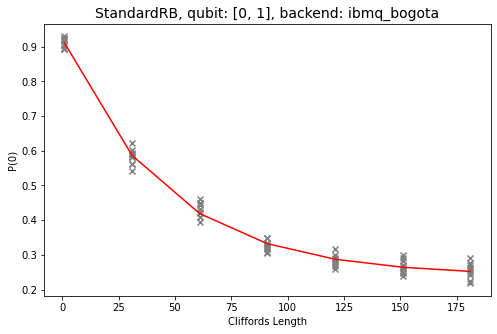

In [62]:
bf.RB_bayesian_results(S2QBh_model, trace_h2, lengths,
                       epc_est_fm,
                       epc_est_fm_err,
                       experiment_type,
                       scale,                       
                       num_samples, Y, shots, physical_qubits, interleaved_gate, backend,
                       EPG_dic = EPG_dic,
                       routine = 'build_bayesian_model')

In [66]:
# example of interpolated EPC_cal for hardware experiments
# EPC0 + (t_exp - tO) * (EPC1 - EPC0) / (t1 - t0)
# code here:
epc_calib = 0.010745 + (22+40/60-7)*(0.008261 - 0.010745)/24
print('EPC calibration: {0:0.4e}'.format(epc_calib))

EPC calibration: 9.1235e-03


# Running 2-qubit Interleaved RB
Note: "EPC" here refers to the error on the interleaved gate

In [45]:
# describe RB experiment
interleaved_gate = "cx"
physical_qubits = qubits = [0,1]
interleaved_circuit = circuits.CXGate()
lengths = np.arange(1, 200, 30) 
num_samples = 10
seed = 1010

In [67]:
# example of interpolated EPC_cal for hardware experiments
# EPC0 + (t_exp - tO) * (EPC1 - EPC0) / (t1 - t0)
# code here:
epc_calib = 0.010745 + (22+19/60-7)*(0.008261 - 0.010745)/24
print('EPC calibration: {0:0.4e}'.format(epc_calib))

EPC calibration: 9.1597e-03


### Least Squares Fit

In [6]:
# Run an interleaved RB experiment

int_exp2 = InterleavedRB(interleaved_circuit, qubits,
                            lengths, num_samples=num_samples, seed=seed)

# Run
int_expdata2 = int_exp2.run(backend).block_for_results()
int_results2 = int_expdata2.analysis_results()

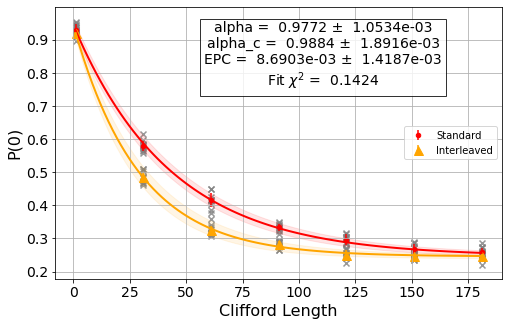

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.69828571 0.97719679 0.98841292 0.24545398] ± [0.01030133 0.00105344 0.00189159 0.0054572 ]
- χ²: 0.14241466371211314
- extra: <3 items>
- device_components: ['Q0', 'Q1']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9771967860198271 ± 0.0010534433118687592
- χ²: 0.14241466371211314
- device_components: ['Q0', 'Q1']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9884129249559458 ± 0.0018915854912259459
- χ²: 0.14241466371211314
- device_components: ['Q0', 'Q1']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.008690306283040655 ± 0.0014186891184194595
- χ²: 0.14241466371211314
- extra: <2 items>
- device_components: ['Q0', 'Q1']
- verified: False


In [7]:
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)

   ### prepare for SMC

In [47]:
popt = int_expdata2.analysis_results()[0].value.value
pcov = int_expdata2.analysis_results()[0].extra['covariance_mat']
popt[2] = popt[1]/popt[2] # replace alpha_C by p_tilde
epc_est_fm = int_expdata2.analysis_results()[3].value.value
epc_est_fm_err = int_expdata2.analysis_results()[3].value.stderr

In [48]:
nQ = len(qubits)
scale = (2 ** nQ - 1) / 2 ** nQ
interleaved_gate ='cx'

In [49]:
# get count data
Y1 = bf.get_GSP_counts(int_expdata2._data, len(lengths),
                    range(0,2*num_samples-1,2))

Y2 = bf.get_GSP_counts(int_expdata2._data, len(lengths),
                    range(1,2*num_samples,2))
int_expdata2._data[1]
experiment_type = int_expdata2._data[0]['metadata']['experiment_type']
physical_qubits = int_expdata2._data[0]['metadata']['physical_qubits']
shots = int_expdata2._data[0]['shots']

###  Serial Monte Carlo, pooled model

model: [equation 6 in this paper](https://arxiv.org/abs/1404.5275) 

In [50]:
Y = np.vstack((Y1,Y2))
RvsI = np.vstack((np.ones_like(Y1),np.zeros_like(Y2)))
IvsR = np.vstack((np.zeros_like(Y1),np.ones_like(Y2)))

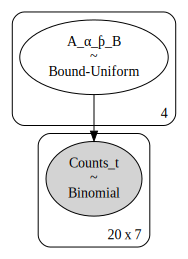

In [14]:
tilde3 =  bf.build_bayesian_model("tilde",Y=Y,shots=shots, m_gates=lengths,
                                         popt = popt,
                                         pcov = pcov,
                                         RvsI=RvsI,IvsR=IvsR)
pm.model_to_graphviz(tilde3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A_α_ƥ_B]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 95 seconds.


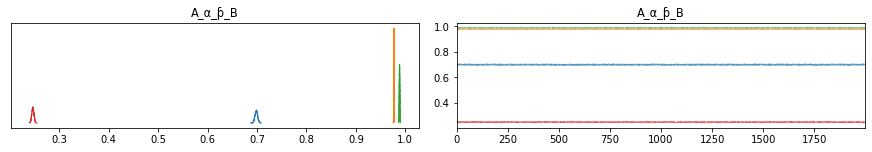

In [15]:
trace_t3 = bf.get_trace(tilde3)

                mean        sd    hdi_3%   hdi_97%
A_α_ƥ_B[0]  0.698459  0.002695  0.693437  0.703574
A_α_ƥ_B[1]  0.977003  0.000349  0.976349  0.977644
A_α_ƥ_B[2]  0.988225  0.000594  0.987152  0.989364
A_α_ƥ_B[3]  0.246567  0.002108  0.242539  0.250427 

Model:    Frequentist         Bayesian        Calibration
__________________________________________________________
EPC         8.690e-03        8.831e-03         9.160e-03
± sigma    ± 1.419e-03      ± 4.455e-04 


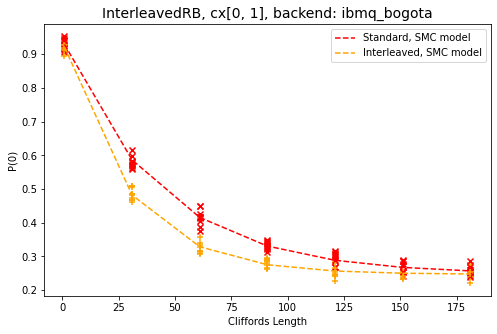

In [51]:
bf.RB_bayesian_results(tilde3, trace_t3, lengths,
                       epc_est_fm, epc_est_fm_err, experiment_type, scale,                      
                       num_samples, Y, shots, physical_qubits, interleaved_gate, backend,
                       epc_calib = epc_calib, Y1 = Y1, Y2 = Y2,
                       routine = 'build_bayesian_model')

###  Serial Monte Carlo, hierarchical model

model: [equation 6 in this paper](https://arxiv.org/abs/1404.5275) and [equation 13 in this paper](https://arxiv.org/abs/1802.00401)

In [52]:
# use 2m length array
RvsI_h = np.ravel(np.vstack((np.ones_like(lengths),np.zeros_like(lengths))))
IvsR_h = np.ravel(np.vstack((np.zeros_like(lengths),np.ones_like(lengths))))

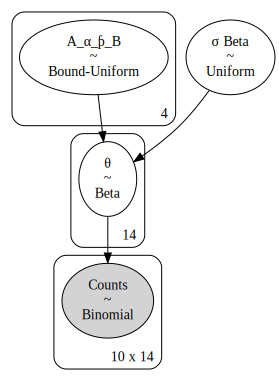

In [53]:
tilde4 =  bf.build_bayesian_model("h_tilde",Y=np.hstack((Y1,Y2)),
                                 shots=shots, m_gates=lengths,
                                 popt = popt,
                                 pcov = pcov,
                                 RvsI = RvsI_h, IvsR = IvsR_h,
                                 sigma_theta=0.005,sigma_theta_l=0.001,sigma_theta_u=0.05)  
                                            

pm.model_to_graphviz(tilde4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, σ Beta, A_α_ƥ_B]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 299 seconds.
The number of effective samples is smaller than 25% for some parameters.


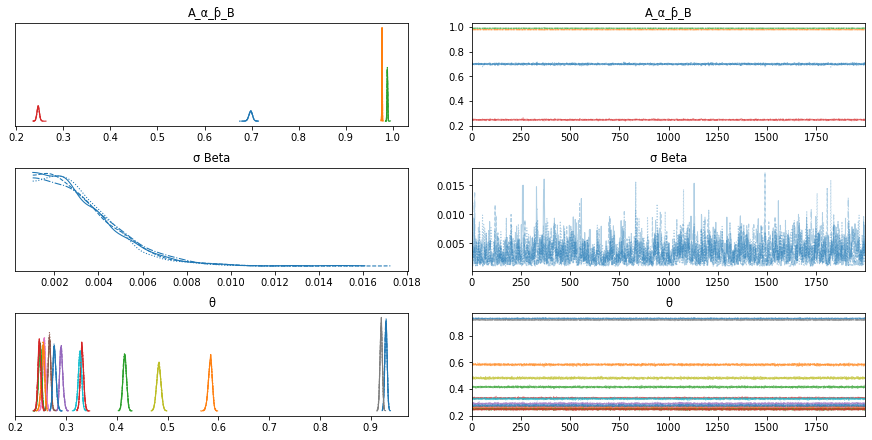

In [20]:
trace_t4 = bf.get_trace(tilde4, target_accept = .99)

                mean        sd    hdi_3%   hdi_97%
A_α_ƥ_B[0]  0.697993  0.004026  0.690345  0.705442
A_α_ƥ_B[1]  0.976985  0.000449  0.976164  0.977856
A_α_ƥ_B[2]  0.988240  0.000755  0.986813  0.989565
A_α_ƥ_B[3]  0.246687  0.002689  0.241647  0.251792
σ Beta      0.003286  0.001814  0.001000  0.006382
θ[0]        0.929732  0.002270  0.925415  0.933961
θ[1]        0.583928  0.003940  0.576319  0.591035
θ[2]        0.415545  0.003558  0.408873  0.422331
θ[3]        0.331529  0.003192  0.325757  0.337820
θ[4]        0.290932  0.003269  0.285470  0.297561
θ[5]        0.267412  0.002850  0.261940  0.272629
θ[6]        0.257362  0.002913  0.251963  0.262975
θ[7]        0.920220  0.002276  0.915999  0.924482
θ[8]        0.482633  0.004280  0.474811  0.490954
θ[9]        0.327330  0.003482  0.320359  0.333445
θ[10]       0.277453  0.003231  0.271756  0.283966
θ[11]       0.254465  0.003167  0.247834  0.259841
θ[12]       0.248894  0.002991  0.243262  0.254489
θ[13]       0.247586  0.002929 

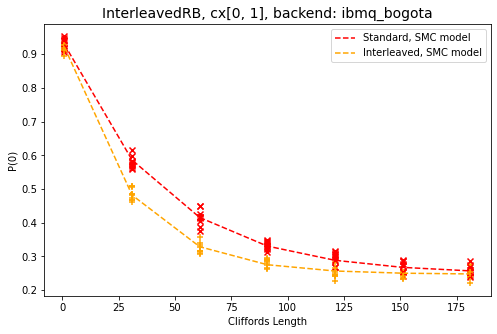

In [54]:
bf.RB_bayesian_results(tilde4, trace_t4, lengths,
                       epc_est_fm, epc_est_fm_err, experiment_type, scale,                       
                       num_samples, Y, shots, physical_qubits, interleaved_gate, backend,
                       epc_calib = epc_calib, Y1 = Y1, Y2 = Y2,
                       routine = 'build_bayesian_model')